In [104]:
import matplotlib.pyplot as plt, numpy as np, noise
from skimage.morphology import (disk, ball)
from skimage.filters import roberts

In [105]:
# Set Radius of island and island seed, plus misc options
seed = 14
r = 100
pond_cutoff = 10
rook_adjacency = False
truncation = False

In [106]:
# Initializing some things for later
d = (r*2)+1
ponds = []
pond_pixels = []

In [107]:
# Define Pixel class for each tile of heightmap
class Pixel:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.vol = 0.1
        self.pointer = self
    
    # Convenience method for printing
    def coordinates(self):
        return (self.x, self.y, self.z)
    
    # Method which returns list of pixels adjacent to a pixel, including the pixel itself
    def get_adjacents(self):
        adjacents = []
        if rook_adjacency == False:
            for i in range(3):
                for j in range(3):
                    adjacents.append(pancake[self.y-1+i][self.x-1+j])
        else:
            adjacents.append(pancake[self.y-1][self.x])
            adjacents.append(pancake[self.y+1][self.x])
            adjacents.append(pancake[self.y][self.x-1])
            adjacents.append(pancake[self.y][self.x+1])
            adjacents.append(self)
        return adjacents
    
    # Method which determines which pixel the pixel will outflow to
    def update_pointer(self):
        to_beat = 999999999
        lowest = self
        for adj in self.get_adjacents():
            if adj.z < to_beat:
                to_beat = adj.z
                lowest = adj
        self.pointer = lowest

In [108]:
# Pond Class definition
class Pond:
    def __init__(self, origin):
        self.members = [origin]
        self.z = origin.z
        self.pointer = origin
        self.vol = 0
        self.edges = [origin]
        self.update_edges()
    
    # Method which determines which pixels are adjacent to the pond, but not members of it
    def update_edges(self):
        adjs = self.pointer.get_adjacents()
        for adj in adjs:
            if (adj not in self.edges) and (adj not in self.members) and (adj in eclair):
                self.edges.append(adj)
        self.edges.remove(self.pointer)
    
    # Method which determines which pixel the pond will outflow to
    def update_pond_pointer(self):
        to_beat = 999999999
        lowest = self.members[0]
        for edge in self.edges:
            if edge.z <= to_beat:
                to_beat = edge.z
                lowest = edge
        self.pointer = lowest
    
    # Method which raises a pond's level until it finds and outflow point (i.e. an adjacent pixel lower than the pond level)
    def rise(self):
#        self.update_edges()
        while True:
            self.update_pond_pointer()
            if self.pointer.z >= self.z:
                
                # Pond collision loop
                for pond in ponds:
                    if pond == self:
                        continue
                    if (self.pointer in pond.members) or (self.pointer in pond.edges):
                        if self.pointer not in pond.members:
                            self.members.append(self.pointer)
                        pond.members += self.members
                        for edge in self.edges:
                            if (edge not in pond.edges) and (edge not in pond.members):
                                pond.edges.append(edge)
                        for edge in pond.edges:
                            if (edge in self.members):
                                pond.edges.remove(edge)
                        ponds.remove(self)
                        pond.rise()
                        break
                
                # Rise update if pond doesn't collide
                if self in ponds:
                    self.update_edges()
                    self.z = self.pointer.z
#                     for member in self.members:
#                         member.z = self.z
                    self.members.append(self.pointer)
                    if self.pointer in self.edges:
                        self.edges.remove(self.pointer)
                else:
                    break
            else:
                break
                
    # Method to determine the volume - NOT level - of a pond. Volume represents the total flowthrough, not pond depth
    def vol_update(self):
        self.vol = 0.1*len(self.members)
        inflows = self.edges
        for inflow in inflows:
            if inflow.pointer in self.members:
                self.vol += inflow.vol

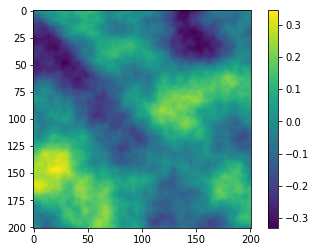

In [109]:
# This cell adapted from https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401 to generate perlin using Noise module
shape = (d,d)
scale = r
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(d):
    for j in range(d):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=seed)
        
plt.imshow(world)
plt.colorbar();

In [110]:
# Generate ball, flatten to 2d array
bosco = ball(r)
biscotti = np.sum(bosco, axis=1)/(d-1)

In [111]:
# Truncation, optional
if truncation == True:
    for i in range(d):
        for j in range(d):
            if biscotti[i][j] > 0.6:
                biscotti[i][j] = 0.6

In [112]:
# Combine world and dome to create textured dome - code to display result commented out
biscuit_land = world+biscotti
# plt.imshow(biscuit_land)
# plt.colorbar();

In [113]:
# Set inundation level based on median altitude and put elevations in terms of sea level
flood = np.median(biscuit_land)
for i in range(d):
    for j in range(d):
        biscuit_land[i][j] -= flood

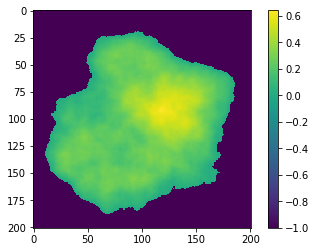

In [114]:
# Inundation visualization - purely graphical
dunked_biscuit = np.zeros((d,d))
for i in range(d):
    for j in range(d):
        if biscuit_land[i][j] < 0:
            dunked_biscuit[i][j] = -1
        else:
            dunked_biscuit[i][j] = biscuit_land[i][j]

plt.imshow(dunked_biscuit)
plt.colorbar();

In [115]:
# Roberts edge detection to determine slopes, this will be used later, commented out for now
# croissant = roberts(biscuit_land)
            
# plt.imshow(croissant)
# plt.colorbar();

In [116]:
# Create array of pixel objects from heightmap
pancake = np.empty(biscuit_land.shape, Pixel)
for i in range(d):
    for j in range(d):
        pancake[i][j] = (Pixel(j, i, biscuit_land[i][j]))

In [117]:
# Create list of pixels from array, excluding array border pixels
eclair = []
for i in range(1,(d-1)):
    for j in range(1,(d-1)):
        eclair.append(pancake[i][j])

In [118]:
# Sort list of pixels by elevation
eclair.sort(key=lambda a : a.z, reverse=True)

In [119]:
# Initial Flow - update pointers and add volume of each pixel to its pointer
for pixel in eclair:
    pixel.update_pointer()
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

In [120]:
# Initial Pond Creation
for pixel in eclair:
    if (pixel.pointer == pixel) and (pixel.vol >= pond_cutoff) and (pixel.z >= 0):
        new_pond = Pond(pixel)
        ponds.append(new_pond)
        new_pond.rise()
        new_pond.vol_update()

# Quick and dirty pond pixel list for vis and conditionals
for pond in ponds:
    for member in pond.members:
        if member not in pond_pixels:
            pond_pixels.append(member)

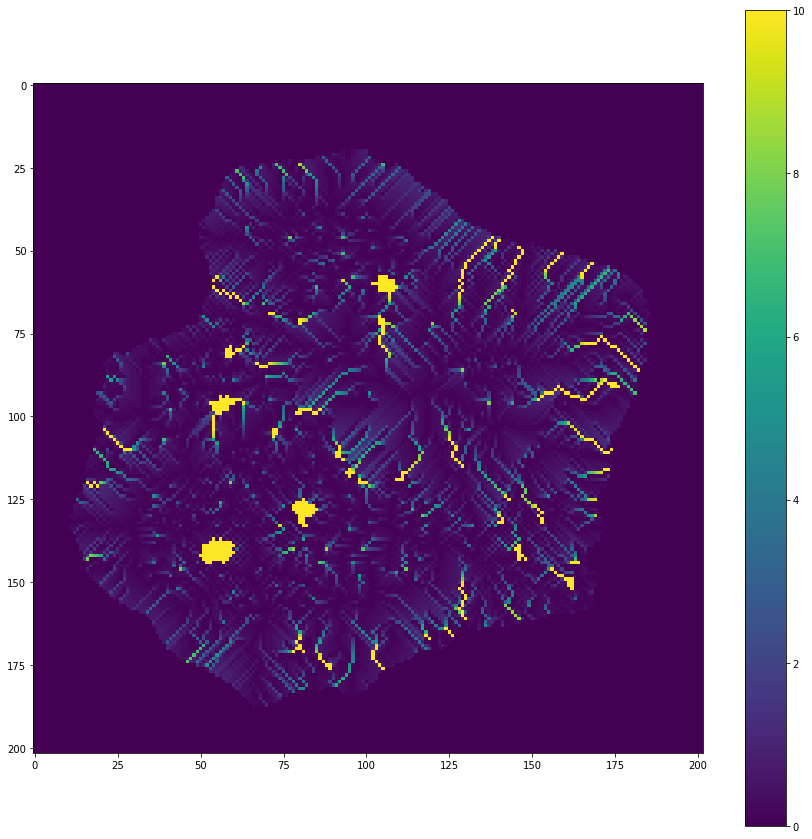

In [121]:
# Full Visualization
plt.figure(figsize=(15,15))
muffin = np.zeros((d+1,d+1))
for i in range(d):
    for j in range(d):
        if pancake[i][j].vol > 10:
            muffin[i][j] = 10
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = 10
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
stale_muffin = muffin

plt.imshow(muffin)
plt.colorbar();
stale_muffin = muffin

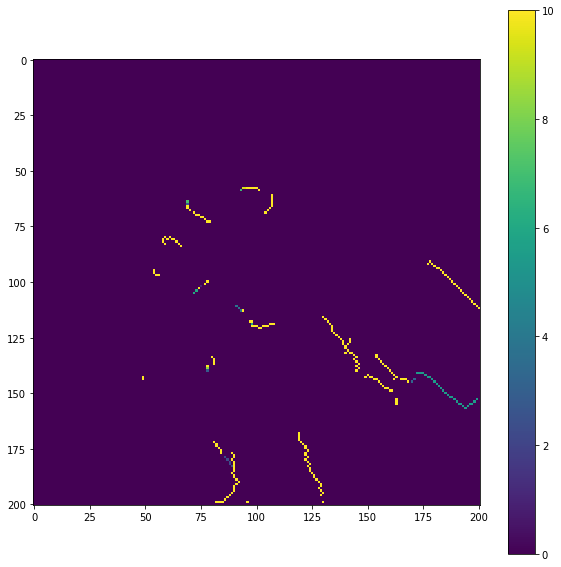

In [122]:
crepe_pond_pixels = []
crepe = np.zeros(shape)
for pond in ponds:
    step = pond.pointer
    step2 = step.pointer
    crepe[step.y][step.x] += pond.vol
    while step != step2:
        crepe[step2.y][step2.x] += crepe[step.y][step.x]
        step = step2
        step2 = step.pointer
    for member in pond.members:
        if member not in crepe_pond_pixels:
            crepe_pond_pixels.append(member)
        
for rang in range(2000):
    for pixel in eclair:
        if (pixel.pointer == pixel) and (crepe[pixel.y][pixel.x] != 0) and (pixel not in crepe_pond_pixels):
            new_pond = Pond(pixel)
            ponds.append(new_pond)
            new_pond.rise()
            new_pond.vol_update()
            step = new_pond.pointer
            step2 = step.pointer
            crepe[step.y][step.x] += new_pond.vol
            while (step != step2) and (step2 in eclair):
                crepe[step2.y][step2.x] += crepe[step.y][step.x]
                step = step2
                step2 = step.pointer
            
            for member in new_pond.members:
                if member not in crepe_pond_pixels:
                    crepe_pond_pixels.append(member)
            
for i in range(d):
    for j in range(d):
        if crepe[i][j] > 10:
            crepe[i][j] = 10
        
plt.figure(figsize=(10,10))        
plt.imshow(crepe)
plt.colorbar();

In [20]:
# Re-Flow with pond volumes
for pixel in eclair:
    pixel.vol = 0.1
    pixel.update_pointer()
for pond in ponds:
    pond.update_pond_pointer()
    pond.pointer.vol += pond.vol
for pixel in eclair:
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

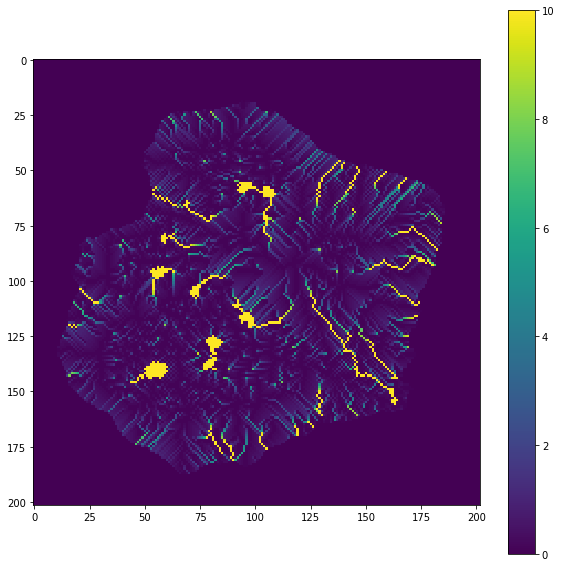

In [21]:
# Full Visualization
plt.figure(figsize=(10,10))
muffin = np.zeros((d+1,d+1))
for i in range(d):
    for j in range(d):
        if pancake[i][j].vol > 10:
            muffin[i][j] = 10
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = 10
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
plt.imshow(muffin)
plt.colorbar();

In [22]:
n = 0
previous_pancake = np.zeros(pancake.shape)
previous_pond = []
#while (pond_pixels[:] != previous_pond[:]) and (pancake.all() != previous_pancake.all()):
for q in range(10):
    previous_pancake = pancake
    previous_pond = pond_pixels[:]
    # Second Pond Creation
    for pixel in eclair:
        if (pixel.pointer == pixel) and (pixel.vol >= pond_cutoff) and (pixel.z >= 0) and (pixel not in pond_pixels):
            new_pond = Pond(pixel)
            ponds.append(new_pond)
            new_pond.rise()
            new_pond.vol_update()
    for pond in ponds:
        for member in pond.members:
            if member not in pond_pixels:
                pond_pixels.append(member)

    # Re-Flow with pond volumes
    for pixel in eclair:
        pixel.vol = 0.1
        pixel.update_pointer()
    for pond in ponds:
        pond.update_pond_pointer()
        pond.pointer.vol += pond.vol
    for pixel in eclair:
        if pixel.pointer != pixel:
            pixel.pointer.vol += pixel.vol
    for pond in ponds:
        pond.vol_update()
    n += 1
    print(n)
print("final n:", n)

1
2
3
4
5
6
7
8
9
10
final n: 10


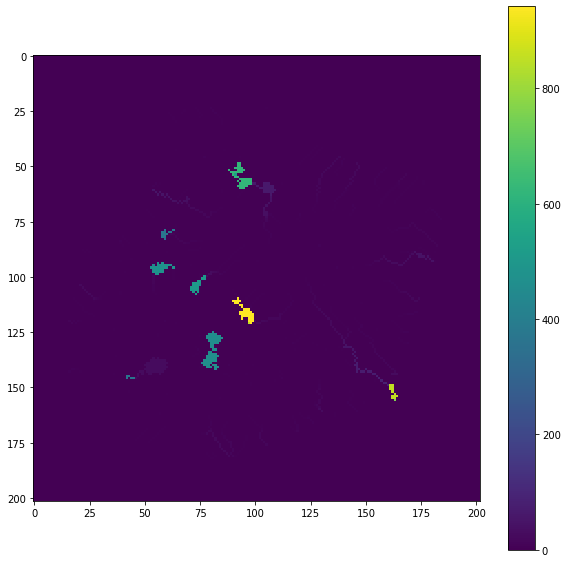

In [23]:
 # Full Visualization
plt.figure(figsize=(10,10))
muffin = np.zeros((d+1,d+1))
for i in range(d):
    for j in range(d):
        if pancake[i][j].vol > 100000000:
            muffin[i][j] = 100000000
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = pond.vol
for i in range(d):
    for j in range(d):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
plt.imshow(muffin)
plt.colorbar();

(╯°□°)╯︵ ┻━┻

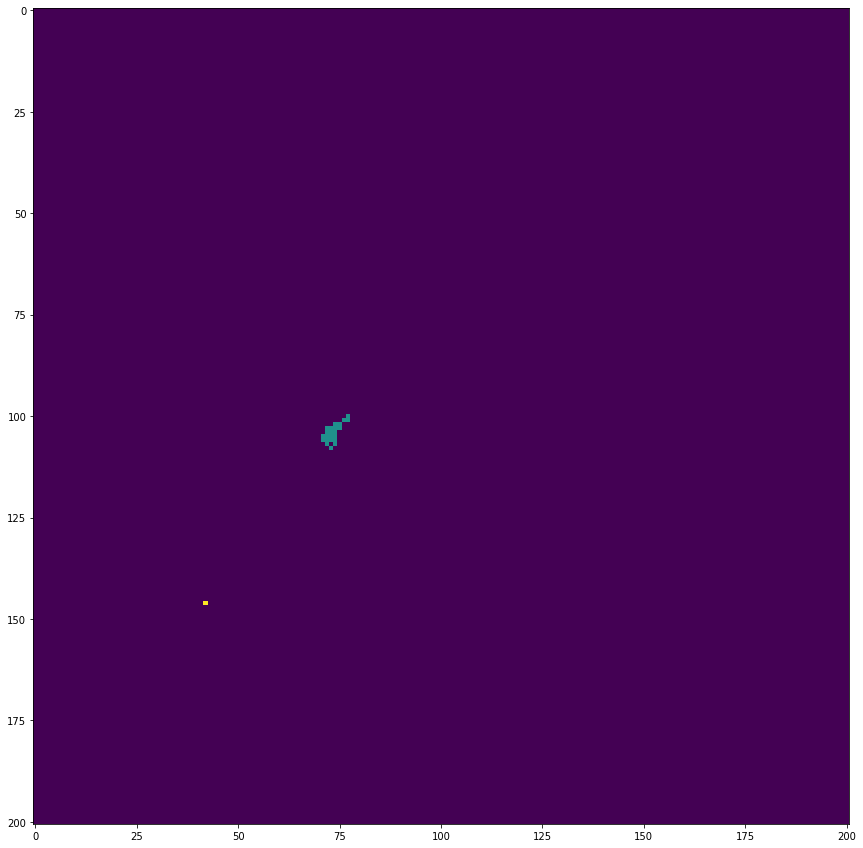

In [24]:
crumpet = np.zeros(shape)
for pixel in eclair:
#    if (pixel in ponds[28].members):
#        crumpet[pixel.y][pixel.x] = 2
    if (pixel in ponds[24].members):
        crumpet[pixel.y][pixel.x] = 1  
crumpet[146][42] = 2
plt.figure(figsize=(15,15))
plt.imshow(crumpet);

In [25]:
[(a.coordinates(), a.vol) if a.pointer in ponds[24].members else "boink" for a in sorted(ponds[24].edges, key=lambda a : a.z, reverse=True)]

[((70, 107, 0.21283527985215178), 0.1),
 'boink',
 ((78, 99, 0.20784057870507233), 0.1),
 'boink',
 'boink',
 ((77, 99, 0.2066570092737674), 0.30000000000000004),
 ((76, 102, 0.20580522909760468), 0.1),
 ((71, 108, 0.20575718358159056), 0.5),
 'boink',
 ((76, 103, 0.20573701158165925), 0.1),
 ((78, 101, 0.20570841625332825), 0.1),
 ((78, 100, 0.20557950630784028), 31.0),
 ((70, 106, 0.20423085764050475), 0.30000000000000004),
 ((74, 109, 0.20395097866654388), 0.1),
 ((71, 102, 0.2038269914686679), 0.1),
 ((73, 101, 0.20128609970211975), 0.1),
 ((70, 104, 0.19873206093907347), 0.1),
 ((72, 109, 0.19855680838227263), 0.2),
 ((71, 103, 0.1982754446566104), 0.2),
 ((70, 105, 0.1981240488588809), 1.0),
 ((71, 107, 0.19784173145890227), 0.2),
 'boink',
 ((76, 104, 0.19704859688878051), 0.1),
 ((74, 108, 0.19689545765519134), 0.1),
 ((75, 108, 0.1964883877336978), 1.8),
 ((72, 108, 0.19618166759610167), 0.7),
 ((74, 101, 0.19554386273026458), 0.2),
 ((75, 101, 0.19535554185509674), 4.3),
 ((7

In [26]:
[(a.coordinates(), a.vol) for a in sorted(ponds[24].members, key=lambda a : a.z, reverse=True)]

[((76, 101, 0.20486818447709076), 0.1),
 ((77, 100, 0.20309075906872742), 0.5),
 ((77, 101, 0.2029563654959201), 31.7),
 ((77, 101, 0.2029563654959201), 31.7),
 ((75, 102, 0.19107720986008636), 0.2),
 ((73, 108, 0.19077728465199462), 3.5),
 ((74, 107, 0.1903066410124301), 2.0),
 ((71, 106, 0.18949153795838347), 0.2),
 ((75, 103, 0.1894199772179126), 0.4),
 ((72, 107, 0.1887810952961444), 4.8),
 ((72, 103, 0.18832923248410216), 0.2),
 ((74, 106, 0.18780335023999206), 1.8000000000000003),
 ((74, 102, 0.18772029116749755), 4.7),
 ((73, 106, 0.18744222059845916), 2.1),
 ((74, 105, 0.18694605663418762), 0.4),
 ((71, 105, 0.1864985354244708), 1.5),
 ((73, 103, 0.18647732570767395), 0.30000000000000004),
 ((74, 104, 0.1855228914320468), 0.30000000000000004),
 ((73, 104, 0.18500261738896362), 0.1),
 ((73, 105, 0.18446172013878814), 2.3000000000000003),
 ((74, 103, 0.18395323291420929), 460.70000000000056),
 ((72, 104, 0.18326712921261779), 0.8),
 ((72, 106, 0.1811725325882434), 5.2),
 ((72, 10

In [27]:
ponds[14].rise()

In [28]:
ponds[14].z

0.14599540188908577

In [29]:
ponds[24].pointer.coordinates()

(75, 104, 0.19178705647587768)

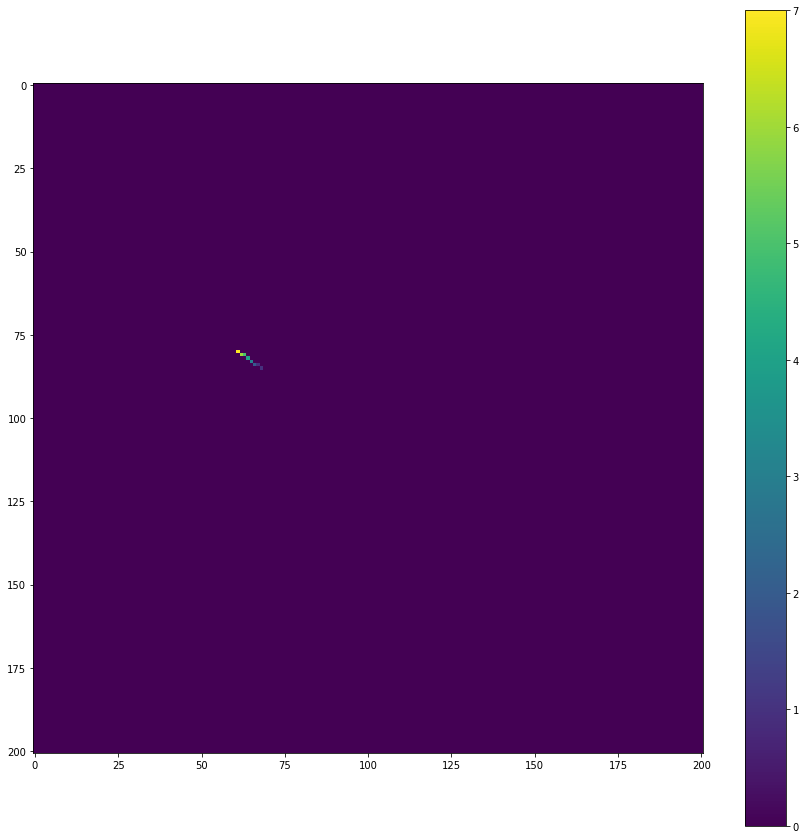

In [30]:
baguette = np.zeros(shape)
for pixel in eclair:
    if pixel in ponds[14].members:
        baguette[pixel.y][pixel.x] = 1
baguette[ponds[14].pointer.y][ponds[14].pointer.x] = 2
baguette[ponds[14].pointer.pointer.y][ponds[14].pointer.pointer.x] = 3
baguette[ponds[14].pointer.pointer.pointer.y][ponds[14].pointer.pointer.pointer.x] = 4
baguette[ponds[14].pointer.pointer.pointer.pointer.y][ponds[14].pointer.pointer.pointer.pointer.x] = 5
baguette[ponds[14].pointer.pointer.pointer.pointer.pointer.y][ponds[14].pointer.pointer.pointer.pointer.pointer.x] = 6
baguette[ponds[14].pointer.pointer.pointer.pointer.pointer.pointer.y][ponds[14].pointer.pointer.pointer.pointer.pointer.pointer.x] = 7
        
plt.figure(figsize=(15,15))
plt.imshow(baguette)
plt.colorbar();

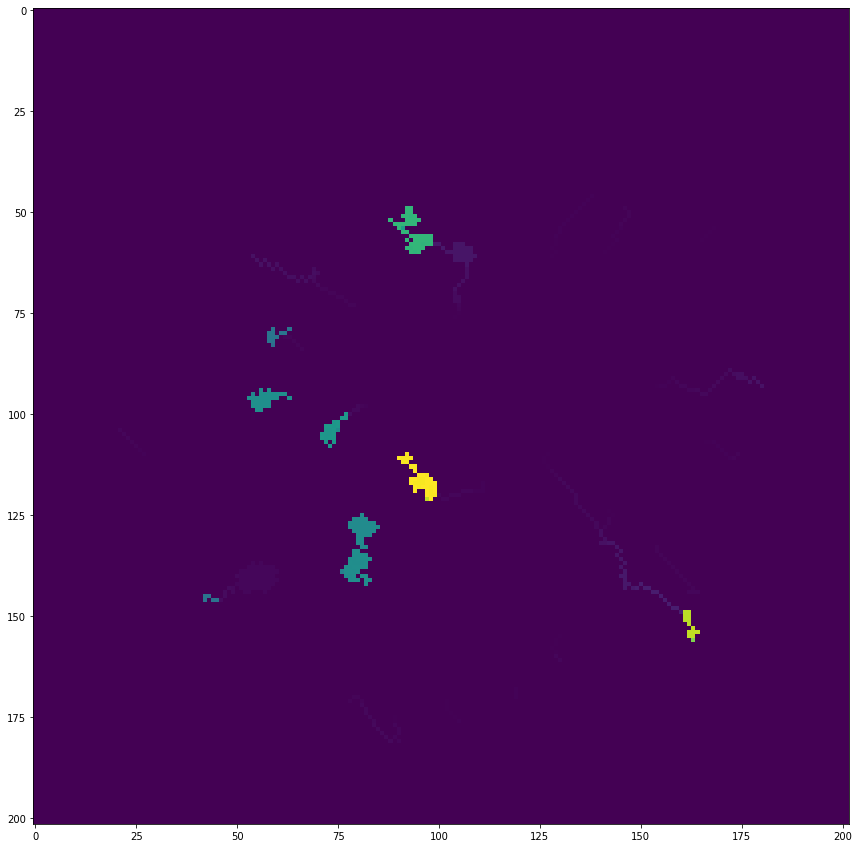

In [31]:
plt.figure(figsize=(15,15))
plt.imshow(muffin-stale_muffin);

In [32]:
print(ponds[14].pointer.vol, ponds[14].pointer.pointer.coordinates(), ponds[14].pointer.pointer.pointer.coordinates(), ponds[14].pointer.pointer.pointer.pointer.vol, ponds[14].pointer.pointer.pointer.pointer.pointer.coordinates(), ponds[14].pointer.pointer.pointer.pointer.pointer.pointer.coordinates())

13.700000000000001 (65, 83, 0.1301855732500553) (64, 82, 0.10892351403832434) 14.0 (62, 81, 0.09543601647019384) (61, 80, 0.08891713634133336)


In [33]:
print([a.coordinates() for a in sorted(pancake[146][44].get_adjacents(), key=lambda a : a.z, reverse=True)])

[(45, 147, 0.2052981810271739), (44, 147, 0.20281950488686562), (45, 145, 0.20152366682887068), (44, 145, 0.1998374344408511), (43, 147, 0.19977398857474327), (43, 146, 0.19864431872963906), (43, 145, 0.19641626730561257), (45, 146, 0.192106600254774), (44, 146, 0.1900712187588215)]


In [34]:
print(pancake[146][44] in pond_pixels)

True


In [35]:
for pond in ponds:
    if pancake[146][44] in pond.members:
        print(ponds.index(pond))

27


In [36]:
ponds[24].pointer.pointer.pointer.coordinates()

(74, 103, 0.18395323291420929)

In [37]:
ponds[24].vol

505.00000000000074

In [38]:
ponds[24].vol_update()

In [39]:
ponds[24].rise()

In [40]:
ponds[24].z

0.20486818447709076

In [41]:
ponds[24].pointer.pointer.pointer.vol

460.70000000000056

In [42]:
for pond in ponds

SyntaxError: invalid syntax (<ipython-input-42-b63e06544766>, line 1)